## 样本划分
所有的样本分成着火探测器台数大于等于16的和小于16但大于等于4的，因为只有大于等于16台的有重建的ne和age，而小于16的没有。

对于一组数据，我们可以用机器学习做3种重建，核种，能量以及方向。
首先先对核种进行鉴别。这里只构造对于核种鉴别所使用的样本。

In [1]:
# 矩阵计算
import numpy as np

# root文件读取
import uproot

# 球面分bin
import healpy as hp

# 画图
import matplotlib.pyplot as plt

# 训练测试集划分
from sklearn.model_selection import train_test_split


读取模拟数据

In [2]:
# 定义我们所需要使用的参数（为了节约内存，不读取所有数据）
paraneed_MC_Pgamma = [
    "nch",
    "theta",
    "phi",
    "sumpf",
    "summd",
    "mr1",
    "cx",
    "cy",
    "ne",
    "age",
    "sigma",
    "inout",
    "prie",
    "pritheta",
    "priphi",
]

In [3]:
# 读取模拟数据，使用的gamma的全天模拟
gammafile = uproot.open("/home2/chenxu/data/gamma_all.root")
# 读取为dict，每一个value为numpy格式
gammadata = gammafile["asresult"].arrays(paraneed_MC_Pgamma, library="np")
gammadata["isgamma"] = np.ones_like(gammadata["nch"])

In [25]:
gammadata

{'nch': array([14,  4, 64, ..., 24, 48,  5], dtype=int32),
 'theta': array([37.55792949, 19.78291059, 19.01030064, ..., 44.76038449,
        42.00619724, 21.60891738]),
 'phi': array([ 98.74059766,  71.91845269,  66.65344964, ...,  25.37058381,
         22.76985877, 123.18343094]),
 'sumpf': array([ 88.56848753,  25.58870963, 391.49823352, ..., 107.36190047,
        243.74535379,  30.54107471]),
 'summd': array([0.        , 0.        , 0.        , ..., 5.69011866, 0.        ,
        0.        ]),
 'mr1': array([22.09847059, 27.6141565 , 34.53956306, ..., 59.30615274,
        50.33985082, 23.55885764]),
 'cx': array([ -0.36683393, 120.17241036,  13.43128319, ...,  39.56831859,
         31.17146753,  64.72273018]),
 'cy': array([-56.15860142,  10.93834901,   2.49053218, ...,  45.5896756 ,
         52.05100972, -36.05243508]),
 'ne': array([-1.00000000e+00, -1.00000000e+00,  2.61632956e+04, ...,
         1.39328367e+04,  3.68184612e+04, -1.00000000e+00]),
 'age': array([-1.        , -1. 

In [4]:
# 定义计算S50函数
from scipy.special import gamma
from math import pi


def getS50(ne: np.ndarray, s: np.ndarray):
    """Get S50 from NKG function.

    Input:
        ne: Ne of Event.
        s: age of Event.

    Output:
        S50
    """
    rm = 130.0
    r = 50.0
    nr = ne / (rm * rm)
    gg1 = gamma(4.5 - s)
    gg2 = 2 * pi * gamma(s) * gamma(4.5 - 2 * s)
    rr1 = pow(r / rm, s - 2)
    rr2 = pow(1 + r / rm, s - 4.5)
    return nr * gg1 / gg2 * rr1 * rr2

In [5]:
# 计算模拟数据的S50
gammadata["S50"] = getS50(gammadata["ne"], gammadata["age"])

### 读取实验数据作为宇宙线


In [6]:
# 读取已知的源数据
knownsorce = np.load("./knownsource.npy")

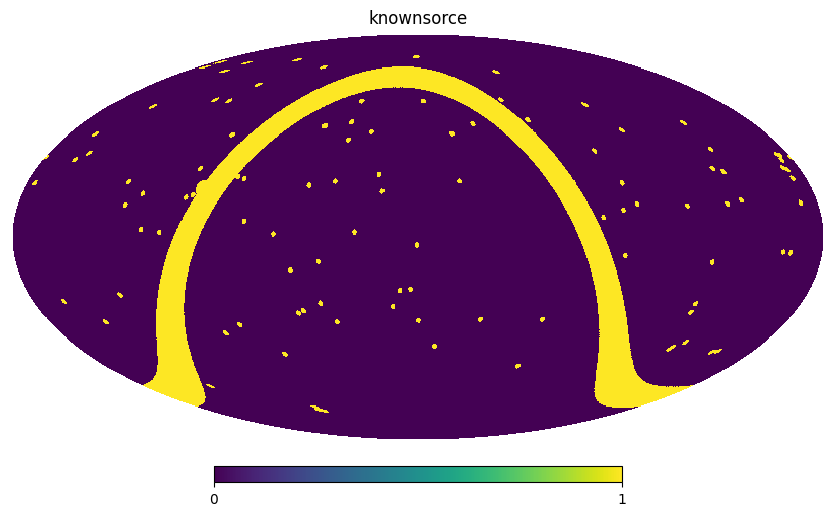

In [7]:
hp.mollview(knownsorce, title="knownsorce")

### 高能样本


### 初步cut
第一步的cut是为了去掉过多的宇宙线事例

$nch>=16$

$sigma<=1$

$inout==1$

$0.301<age<1.599$

$summd<0.4$ or $summd<1.2e-3*sumpf^{1.6}$

$theta<60$

In [11]:
gammadata_need_high = np.where(
    (gammadata["nch"] >= 16)
    & (gammadata["sigma"] < 1)
    & (gammadata["inout"] == 1)
    & (gammadata["age"] > 0.301)
    & (gammadata["age"] < 1.599)
    & (
        (gammadata["summd"] < 0.4)
        | (gammadata["summd"] < 1.2e-3 * gammadata["sumpf"] ** 1.6)
    )
    & (gammadata["theta"] < 60)
)

In [10]:
gammadata_need_high[0].shape

(2204412,)

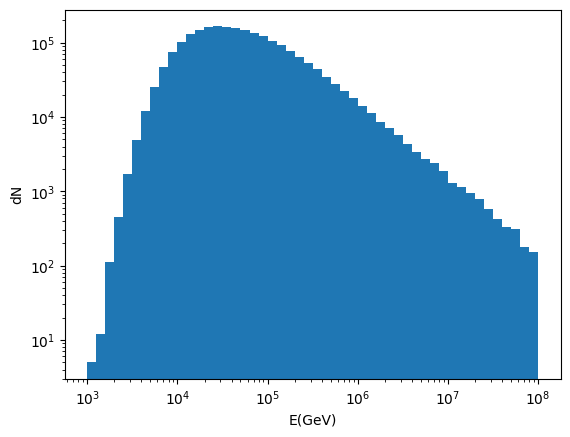

In [12]:
# 这段样本的能量(最高能量是设置最高能量)
plt.hist(gammadata["prie"][gammadata_need_high], bins=np.logspace(3, 8, 51))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("E(GeV)")
plt.ylabel("dN")
plt.show()

### 读取实验数据作为宇宙线


实验数据先卡了一刀

$nch>=16$

$sigma<=1$

$0.301<age<1.599$

$summd<0.4$ or $summd<1.2e-3*sumpf^{1.6}$

$theta<60$

In [13]:
# 卡这一刀的代码如下

# def mkdir(path):
#     if not os.path.exists(path):
#         os.makedirs(path)


# def preprocessing(data_path_dirname):
#     """test"""
#     file = uproot.open(data_path_dirname)
#     data = file["asresult"].arrays(
#         [
#             "runno",
#             "evno",
#             "mjd",
#             "nch",
#             "theta",
#             "phi",
#             "sigma",
#             "cx",
#             "cy",
#             "sumpf",
#             "summd",
#             "mr1",
#             "ne",
#             "age",
#         ],
#         library="np",
#     )
#     cut = np.where(
#         (data["nch"] >= 16)
#         & (data["sigma"] <= 1)
#         & (data["age"] > 0.301)
#         & (data["age"] < 1.599)
#         & ((data["summd"] < 0.4) | (data["summd"] < 1.2e-3 * data["sumpf"] ** 1.6))
#     )
#     data = {key: data[key][cut] for key in data.keys()}
#     mkdir("/home/hky/Data/highEnergy_ag_pgamma/" + data_path_dirname[-20:-13])
#     np.savez("/home/hky/Data/highEnergy_ag_pgamma/" + data_path_dirname[-20:-5] + ".npz", **data)
#     print("/home/hky/Data/highEnergy_ag_pgamma/" + data_path_dirname[-20:-5] + ".npz")


# if __name__ == "__main__":
#     data_path_dirname = sys.argv[1]
#     preprocessing(data_path_dirname)

对于高能部分在这个cut条件下，每20分钟大约有5200事例，模拟的gamma剩余2204412例，选择宇宙线事例和gamma事例基本相同，因此选择约500个实验文件作为宇宙线。并排除掉来自已知源的事例。

In [14]:
import tqdm
import random

def pickevent(eventnumber, datapath, savepath):
    paralist_Expt = [
        "nch",
        "theta",
        "phi",
        "sigma",
        "cx",
        "cy",
        "sumpf",
        "summd",
        "mr1",
        "ne",
        "age",
        "mjd",
        "S50",
    ]
    AllskyData = dict()
    for key in paralist_Expt:
        AllskyData[key] = list()
    datalist = list()
    for root, dirs, files in os.walk(datapath, topdown=False):
        for name in files:
            datalist.append(os.path.join(root, name))

    for path in tqdm(random.sample(datalist, eventnumber)):
        Exptdata = np.load(path)
        Exptdata = {key: Exptdata[key] for key in Exptdata}
        Exptdata["S50"] = getS50(Exptdata["ne"], Exptdata["age"])

        for key in paralist_Expt:
            AllskyData[key].append(Exptdata[key])
    for key in paralist_Expt:
        AllskyData[key] = np.concatenate(AllskyData[key])
    np.savez(savepath, **AllskyData)

In [15]:
# 挑出500个高能实验文件
# pickevent(500,"/home/hky/Data/highEnergy_ag_pgamma/","./highEnergy_ag_pgamma.npz")
AllskyData_highEnergy = np.load("./highEnergy_ag_pgamma.npz")
AllskyData_highEnergy = {
    key: AllskyData_highEnergy[key] for key in AllskyData_highEnergy
}

In [16]:
# 单位与坐标变换
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time


def corrdinateYBJ2J2000(theta, phi, mjd):
    """Transform YBJ ALTAZ to J2000

    Args:
        theta (np.array): zenith angle in location coordinates
        phi (np.array): Azimuth angle in location corrdinates
        mjd (np.array): mjd
    Returns:
        np.array: List of two np.array, first is ra with degree, second is dec with degree.
    """
    # start = time.time()
    # print("===========start========")
    YBJ_Location = EarthLocation(
        lat=30.102 * u.deg, lon=90.522 * u.deg, height=4300 * u.m
    )
    mjdtime = Time(mjd, format="mjd", location=YBJ_Location)
    newAltAzcoordiantes = SkyCoord(
        alt=(90 - theta) * u.deg,
        az=phi * u.deg,
        obstime=mjdtime,
        frame="altaz",
        location=YBJ_Location,
    )
    RaDec = newAltAzcoordiantes.icrs
    Ra = RaDec.ra.degree
    Dec = RaDec.dec.degree
    return [
        Ra,
        Dec,
    ]


def remove_knownsource(data, knownsource):
    NSIDE = hp.npix2nside(len(knownsource))
    data["Ra"], data["Dec"] = corrdinateYBJ2J2000(
        data["theta"], data["phi"], data["mjd"]
    )
    pix = hp.ang2pix(NSIDE, data["Ra"], data["Dec"], lonlat=True)
    need = np.where(knownsource[pix] == 0)
    data = {key: data[key][need] for key in data.keys()}
    return data

In [17]:
AllskyData_highEnergy = remove_knownsource(AllskyData_highEnergy, knownsorce)

In [29]:
AllskyData_highEnergy["isgamma"] = np.zeros_like(AllskyData_highEnergy["nch"])

In [30]:
highEnergydata = dict()
paralist = [
        "nch",
        "theta",
        "phi",
        "sigma",
        "cx",
        "cy",
        "sumpf",
        "summd",
        "mr1",
        "ne",
        "age",
        "S50",
        "isgamma",
    ]
for para in paralist:
    highEnergydata[para] = np.concatenate(
        [
            AllskyData_highEnergy[para],gammadata[para][gammadata_need_high]
        ]
    )

In [31]:
# 训练集测试集划分（训练集80%）
train_index, test_index = train_test_split(
    range(len(highEnergydata["isgamma"])), test_size=0.2, random_state=42
)
trainData = {key: highEnergydata[key][train_index] for key in highEnergydata.keys()}
testData = {key: highEnergydata[key][test_index] for key in highEnergydata.keys()}
np.savez(
    "./highEnergy_trainData.npz",
    **trainData
)
np.savez(
     "./highEnergy_testData.npz",
    **testData
)

## 低能样本

### 初步cut
第一步的cut是为了去掉过多的宇宙线事例

$nch>=4$

$sigma<=1$

$inout==1$

$summd<0.4$ 

$theta<60$

In [6]:
gammadata_need_low = np.where(
    (gammadata["nch"] >= 4)
    & (gammadata["sigma"] < 1)
    & (gammadata["inout"] == 1)
    & (gammadata["summd"] < 0.4)
    & (gammadata["theta"] < 60)
)

In [7]:
gammadata_need_low[0].shape

(7608160,)

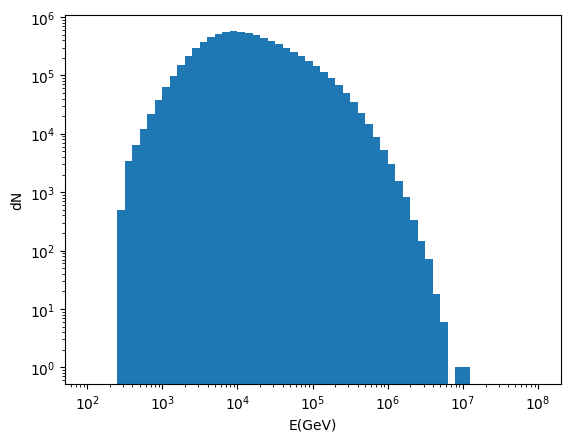

In [8]:
# 这段样本的能量
plt.hist(gammadata["prie"][gammadata_need_low], bins=np.logspace(2, 8, 61))

plt.yscale("log")
plt.xscale("log")
plt.xlabel("E(GeV)")
plt.ylabel("dN")
plt.show()

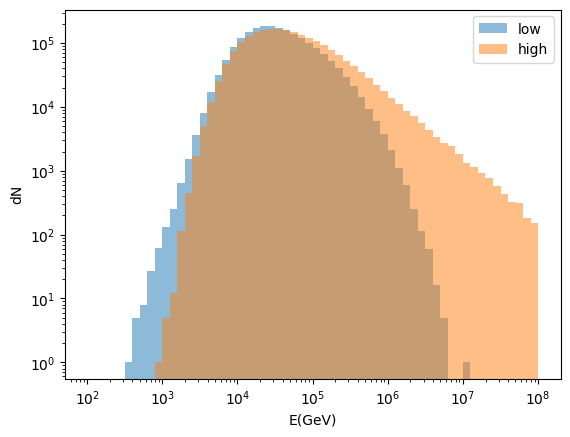

In [15]:
gammadata_need_low_sumpf_200 = np.where(
    (gammadata["nch"] >= 4)
    & (gammadata["sigma"] < 1)
    & (gammadata["inout"] == 1)
    & (gammadata["summd"] < 0.4)
    & (gammadata["theta"] < 60)
    & (gammadata["sumpf"] > 100)
)
# 这段样本的能量
plt.hist(
    gammadata["prie"][gammadata_need_low_sumpf_200],
    bins=np.logspace(2, 8, 61),
    alpha=0.5,
    # density=True,
    label="low"
)
plt.hist(
    gammadata["prie"][gammadata_need_high],
    bins=np.logspace(2, 8, 61),
    alpha=0.5,
    # density=True,
    label="high"
)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("E(GeV)")
plt.ylabel("dN")
plt.legend()
plt.show()


对于低能部分在这个cut条件下，每20分钟大约有34000事例，模拟的gamma剩余7608160例，选择宇宙线事例和gamma事例基本相同，因此选择约300个实验文件作为宇宙线。并排除掉来自已知源的事例。

In [21]:
# 挑选出300个低能实验文件
# pickevent(300,"/home/hky/Data/lowEnergy_ag_pgamma/","./lowEnergy_ag_pgamma.npz")
AllskyData_lowEnergy = np.load("./lowEnergy_ag_pgamma.npz")
AllskyData_lowEnergy = {
    key: AllskyData_lowEnergy[key] for key in AllskyData_lowEnergy
}

In [22]:
AllskyData_lowEnergy = remove_knownsource(AllskyData_lowEnergy, knownsorce)

In [33]:
AllskyData_lowEnergy["isgamma"] = np.zeros_like(AllskyData_lowEnergy["nch"])

In [34]:
lowEnergydata = dict()
paralist = [
        "nch",
        "theta",
        "phi",
        "sigma",
        "cx",
        "cy",
        "sumpf",
        "summd",
        "mr1",
        "isgamma",
    ]
for para in paralist:
    lowEnergydata[para] = np.concatenate(
        [
            AllskyData_lowEnergy[para],gammadata[para][gammadata_need_low]
        ]
    )

In [ ]:
# 训练集测试集划分（训练集80%）
train_index, test_index = train_test_split(
    range(len(lowEnergydata["isgamma"])), test_size=0.2, random_state=42
)
trainData = {key: lowEnergydata[key][train_index] for key in lowEnergydata.keys()}
testData = {key: lowEnergydata[key][test_index] for key in lowEnergydata.keys()}
np.savez(
    "./lowEnergy_trainData.npz",
    **trainData
)
np.savez(
     "./lowEnergy_testData.npz",
    **testData
)